## Student Name: Akshata Bheemasamudra Mallikarjunappa

## Student ID: 23164204

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [3]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [4]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [5]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_errors = 1- train_scores
    test_errors = 1-test_scores

    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")


    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [7]:
class MLPWrapper(BaseEstimator, ClassifierMixin):

    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [8]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=100,
)

In [9]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=100,
)

# Solutions

**Reflection for the entire notebook is broken down after each experimentation of different hyperparameter values. I have also added a brief introductory understanding of the concepts and terms in general**

## Task 1

**Reflection:**

SVM ensures that while when we are creating a hyperplane, it also creates two additional parallel marginal hyperplanes (margin lines) which are separated by some distance from the main hyperplane in order for the data to be easily linearly separable for both the classification points. The main hyperplane ensures the other two lines are created and that they pass through at least one of the nearest data points of each class.

Margin, the distance between the first marginal hyperplane and the second marginal hyperplane.
Significance of this margin – We have to create a generalized model for better accuracy. Any point that falls above the brown marginal hyperplane will belong to the brown data points, any point that falls below the bottom marginal plane will be classified as the blue colored data points. This marginal hyperplane concept acts as a cushion to classify the points better.

TThe main aim in SVM concept is to maximise the marginal plane distance, based on that we select the hyperplane which has the best maximum distance between the two marginal planes.

Support Vectors are the data points that are passing through the two marginal planes. This helps us to determine the maximum distance of the marginal plane.

C is the regularization parameter that controls the trade-off between maximizing the margin and minimizing the classification error,
This parameter controls the trade-off between achieving a low training error and minimizing the norm of the weights.

When the data is linearly separable, and we don't want to have any misclassifications, we use SVM with a hard margin. However, when a linear boundary is not feasible, or we want to allow some misclassifications in the hope of achieving better generality, we can opt for a soft margin for our classifier

In [ ]:
df = pd.read_csv('/content/dataset_1_train.csv', header = None)
df.head()

0         1    2
0  0.913385 -0.131071  1.0
1 -1.393895 -1.373790  0.0
2 -0.379568  1.404829  0.0
3  1.525722 -1.713379  1.0
4  1.444181 -0.622548  1.0

In [ ]:
X = df.loc[:,:1].to_numpy()
y = df.loc[:,2].to_numpy()


SVC(kernel='linear')

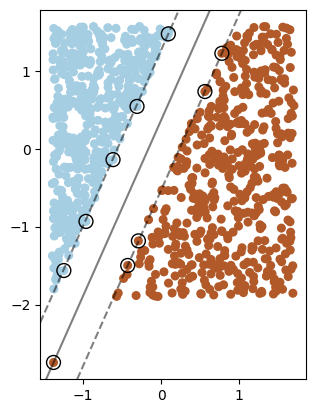

In [ ]:
c1 = svm.SVC(C=1, kernel='linear')
c1.fit(X,y)
plot_margin(X,y,c1)
plt.show()

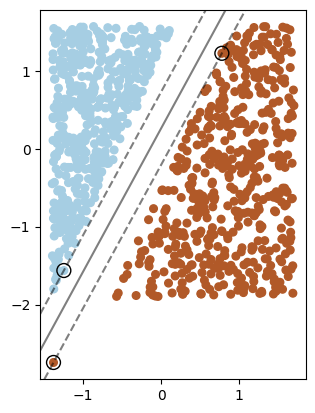

In [ ]:
c10 = svm.SVC(C=10, kernel='linear')
c10.fit(X,y)
plot_margin(X,y,c10)
plt.show()

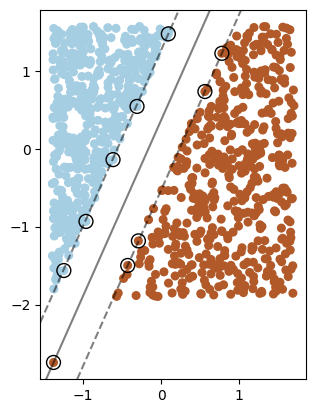

In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y)
plot_margin(X,y,clf)
plt.show()

The above experiment for default value of C which is equal to 1, the two margin planes are correctly passing through respective data points and the distance also seem to be reasonable.However there is one outlier datapoint whicch is not classified correctly within the right side of the graph. But this should be acceptable to an extent if we are aiming to make the model more generalized and the missclassification is not a lot. Because otherwise we would be overfitting or underfitting. We should also note that it is considering the outermost / first line of data points and so only those few data points in the first line are highlighted. Making note of this will help us understand how the margin line / margin plane is moving w.r.t change in regularization (C) value.

Thie sscenario is called as moderate margin SVM model.


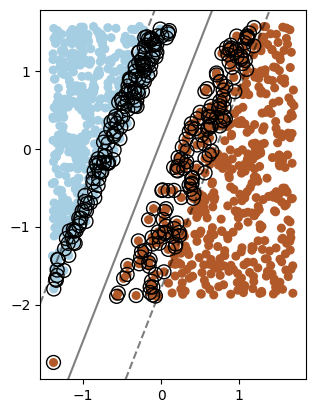

In [ ]:
c001 = svm.SVC(C=0.01, kernel='linear')
c001.fit(X,y)
plot_margin(X,y,c001)
plt.show()

In [ ]:

# C-parameter to find the widest margin solution with a hard margin and a soft margin.
clf_smallC = svm.SVC(C = 0.1, kernel='linear')
clf_smallC.fit(X, y)

SVC(C=0.1, kernel='linear')

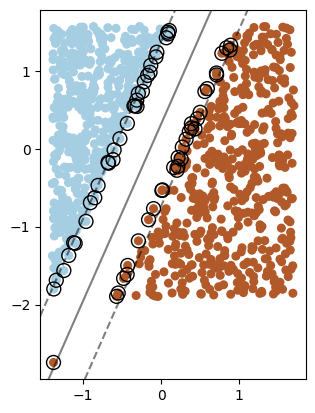

In [ ]:
plot_margin(X,y,clf_smallC)
plt.show()

The C parameter value has decreased from 10 to 0.1
With decrease in C value, that is, for a small value of the distance between the two marginal planes increase, We have a wider margin boundary which is more likely to classify all the points correctly as the marginal planes moved farther from the hyperplane covering a lot of data points which helps the model learn the data point belongingness to repsective class easily. In contrast to the first case, we can see more data points are covered (highlighted) which can be used to confirmed that the margins have moved more towards the data points increasing the distance. This may lead to underfitting leading to many misclassified data points on unseen data.

The model has soft SVM margin

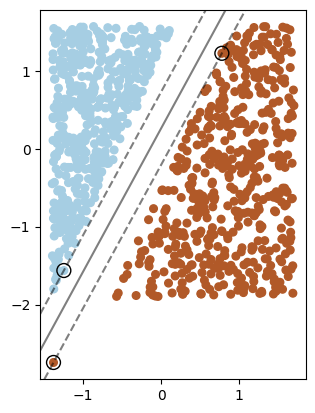

In [ ]:
clf_bigC = svm.SVC(C = 100, kernel='linear')
clf_bigC.fit(X, y)
plot_margin(X,y,clf_bigC)
plt.show()

This model is called the hard margin SVM model.

The C parameter values has been increased to 100. The larger the value of C, the ditance between the margin decreases. Because there isn't enough data points on the margin plane to learn from, it may prform well on training data however it is more likely to missclassify on unseen data leading to overfitting. A larger value of penalizes misclassifications more heavily. This leads to a higher likelihood of the algorithm classifying all training examples correctly, potentially resulting in overfitting. We can see the brown outlier like data point which was classified on the hyperplane is now very accurately being classified as belonging to brown data point class. This is a sign we are making the model very precise and is not a good sign of a generalized model.

**FINAL Reflection**

After one of my peers pointed out about the default value, I cross-checked again and the conclusion is as below,

The default value of C is 1 for which,
C=1 & also C=default has same number of support vectors captured meaning marginal distance is same. and outlier (brown data point) also does not change, that is, it lies on the hyper-plane.

When, C=10 & C=100 two support vectors are captured which implies the distance between the marginal planes has decreased, but the outlier outlier is correctly classified. This is hard margin model and is overfitting.

When C = 0.1, good no of support vectors are detected and outlier lies on the hyper-plane however the soft margin was detected when C = 0.01, more number of support vectors were captured compared to when C = 0.1 due to larger increase in the marginal distance and the outlier is misclassified which suggests an underfitting model.

Best Values: I chose these values considering the intial distanc ebetweent he two classes and this may be subject to change depending on the datasets and initial the distance between the classes. But for this problem, the below values were able to prominently highlight difference.

Generalized model: C = 1 which is the default for a reason.

Hard Margin (overfitting): C = 100

Soft Margin (underfitting): C = 0.01

# **Task 2**

The SVM has differekt kernels to perform different kind of classification. Therefore this acts as a linear classifier as well as non-linear classifier. We can say SVM is similar to linear regression/linear classification except that when it is using linear kernel, along with the main hyperplane it also has two parallel marginal planes on each side of the data point / classes. Hence, we use linear kernel in SVm to classify linear data.

As mentioned in task 1, these marginal planes help the model to generalize better with more accuracy.

Now, if the data is non-linearly separable, the SVM models use RBF kernel ( radial basis function) transforms the 2d low dimensional data into 3d high dimensional data internally which helps create a 3d hyperplane between the two non-linear separable classes and can be classified easily. The two parameters, C to control error and gamma decides that how much curvature we want in a decision boundary, play an important role for kernels.

We need to note that only rbf kernel uses both c and gamma hyperparameters.

In [15]:
df_2_train = pd.read_csv('/content/dataset_2_train.csv', header=None)
df_2_test = pd.read_csv('/content/dataset_2_test.csv', header=None)

df_3_train = pd.read_csv('/content/dataset_3_train.csv', header=None)
df_3_test = pd.read_csv('/content/dataset_3_test.csv', header=None)

print(df_2_train.head())
print('\n', df_3_train.head())
print('\n', df_2_test.head())
print('\n', df_3_test.head())


          0         1    2
0  0.489763 -1.319059  1.0
1  1.218091  0.027041  1.0
2 -0.756690 -0.834019  1.0
3 -0.225763  0.500619  0.0
4 -1.465371 -0.932708  1.0

           0         1    2
0  1.365763 -0.852968  0.0
1  1.533025  0.939828  0.0
2 -0.377235 -0.568328  1.0
3  1.132488 -0.339363  0.0
4  1.282092 -0.366779  0.0

           0         1    2
0  1.650663  1.483684  1.0
1 -1.358237 -0.456899  0.0
2  1.508070  1.613134  1.0
3  0.775682 -0.648303  1.0
4 -1.263360  0.381345  0.0

           0         1    2
0  1.429640  1.573458  0.0
1  0.388578  1.704281  0.0
2  0.589056 -0.487875  1.0
3  1.220130 -1.361466  0.0
4  1.065026  1.559217  0.0


In [13]:
print(X2_train.shape)
y2_train.shape

(670, 2)


(670,)

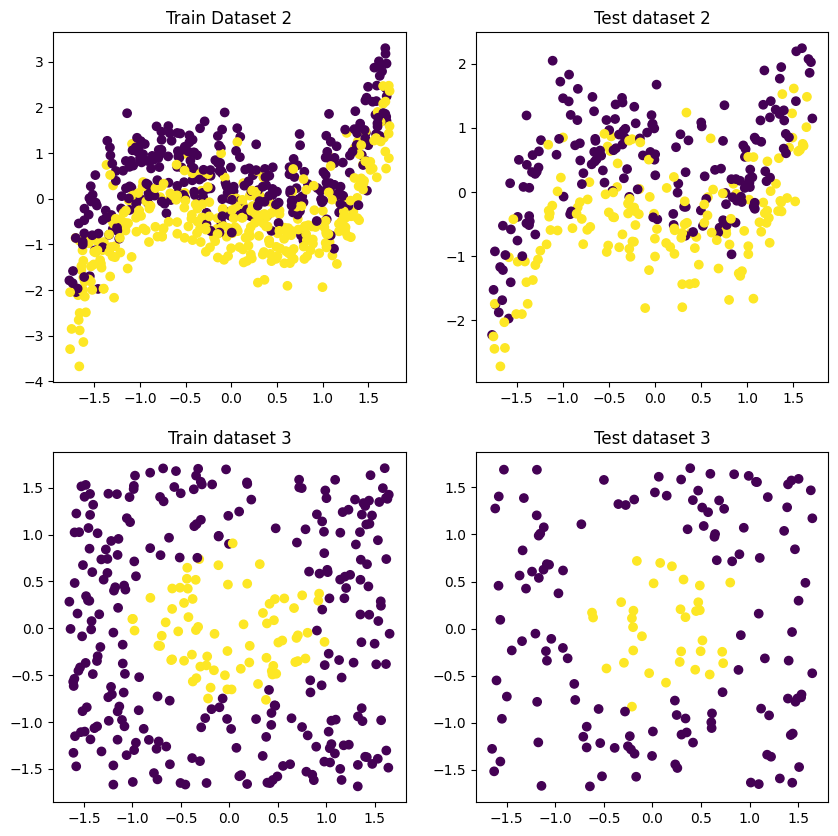

In [16]:
X2_train = df_2_train.loc[:,:1].to_numpy()
y2_train = df_2_train.loc[:,2].to_numpy()
X2_test = df_2_test.loc[:,:1].to_numpy()
y2_test = df_2_test.loc[:,2].to_numpy()

X3_train = df_3_train.loc[:,:1].to_numpy()
y3_train = df_3_train.loc[:,2].to_numpy()
X3_test = df_3_test.loc[:,:1].to_numpy()
y3_test = df_3_test.loc[:,2].to_numpy()


figure, axis = plt.subplots(2, 2,figsize=(10, 10))

axis[0, 0].scatter(X2_train[:, 0], X2_train[:, 1], c=y2_train)
axis[0, 0].set_title("Train Dataset 2")

axis[0, 1].scatter(X2_test[:, 0], X2_test[:, 1], c=y2_test)
axis[0, 1].set_title("Test dataset 2")

axis[1, 0].scatter(X3_train[:, 0], X3_train[:, 1], c=y3_train)
axis[1, 0].set_title("Train dataset 3")

axis[1, 1].scatter(X3_test[:, 0], X3_test[:, 1], c=y3_test)
axis[1, 1].set_title("Test dataset 3")

plt.show()

# **small value of C and gamma for dataset 2 & 3**

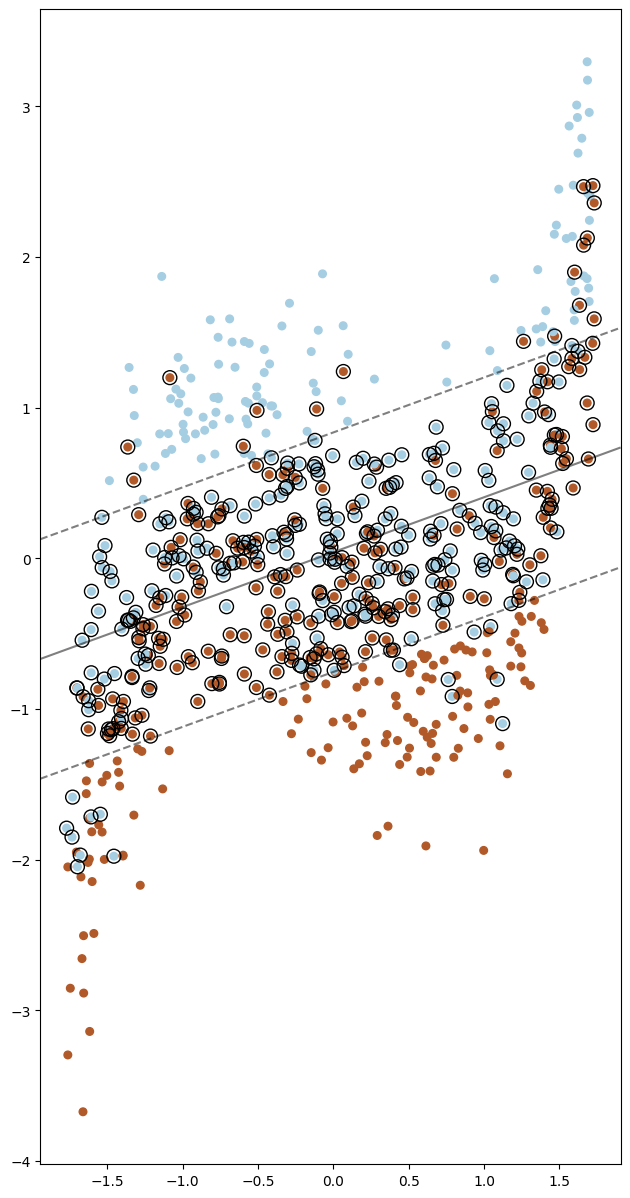

Accuracy of the model is 0.6888217522658611


In [ ]:
classifier2 = svm.SVC(C = 0.01, kernel = 'linear')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score


plt.figure(figsize=(15, 15))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

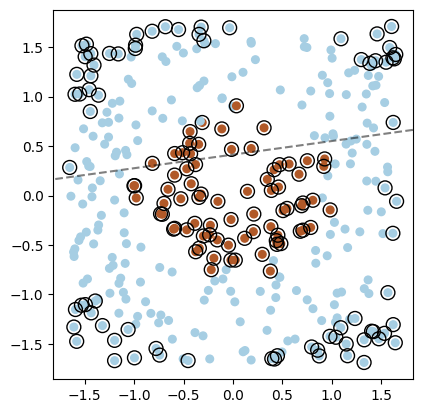

Accuracy of the model is 0.8


In [ ]:
classifier3 = svm.SVC(C = 0.01, kernel = 'linear')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

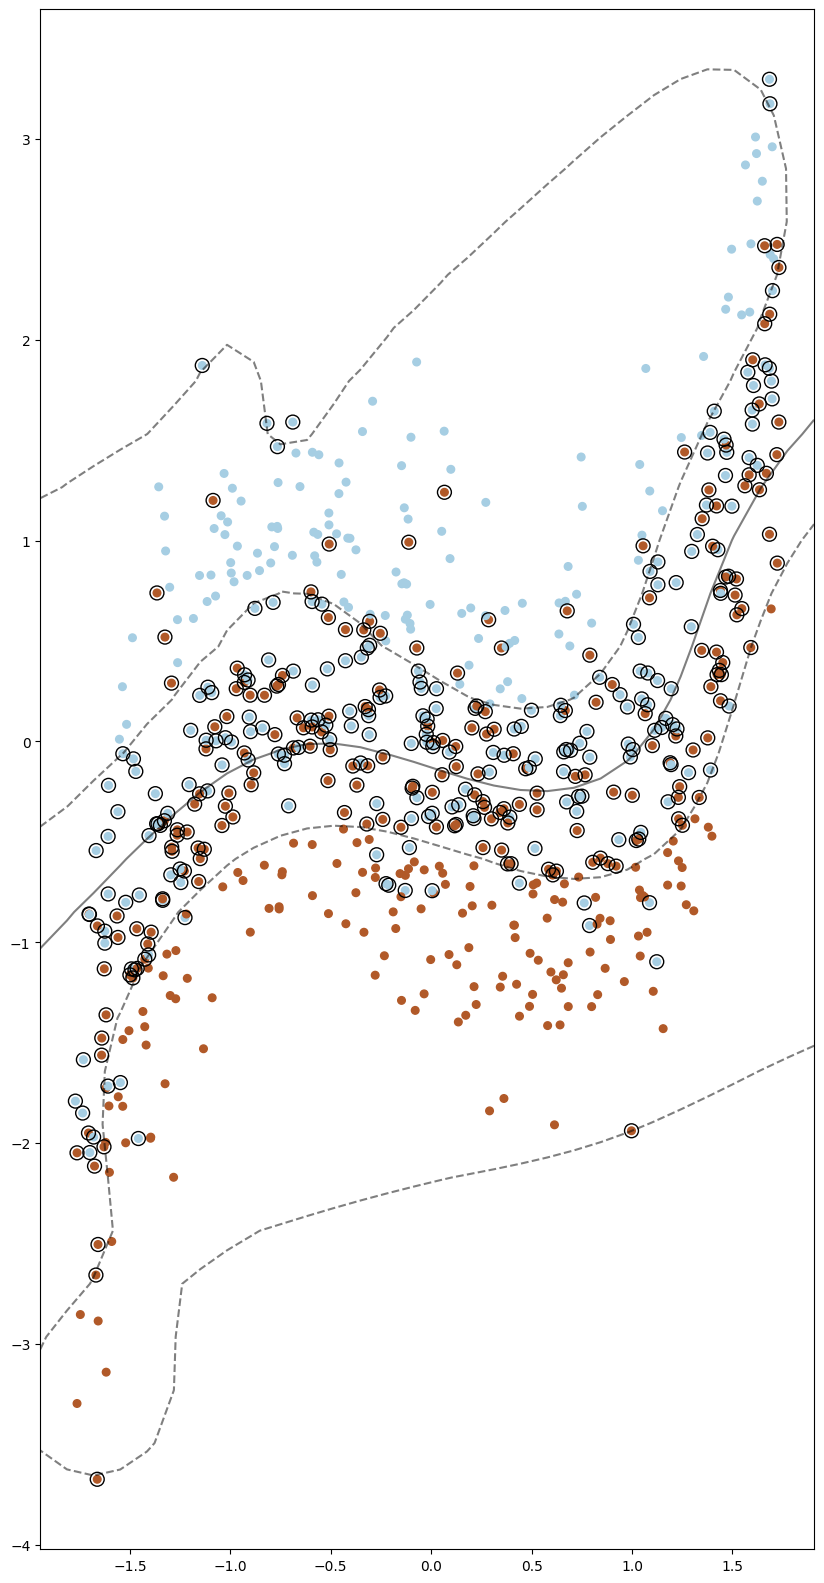

Accuracy of the model is 0.7462235649546828


In [ ]:
classifier2 = svm.SVC(C = 0.01, gamma = 0.01, kernel = 'rbf')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plt.figure(figsize=(15, 15))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

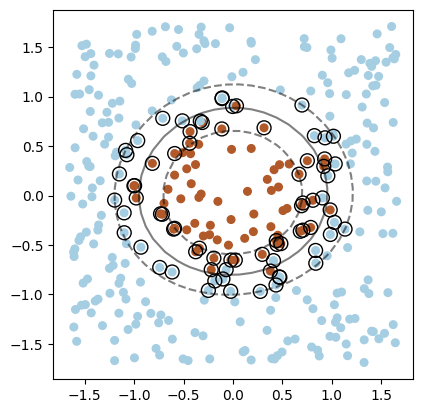

Accuracy of the model is 0.9636363636363636


In [ ]:
classifier3 = svm.SVC(C = 0.01, gamma= 0.01, kernel = 'rbf')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

 Dataset 2 and 3 are not linearly separable. The linear kernel draws a straight line to separate the data points however a lot of data points are misclassified for dataset 2 and the test error is quite low at 68%. For dataset 3, the accuracy increases to 80% and we can see that the decision boundary drawn is trying to classify both brown and blue data points as one class. Also, there is noise in dataset2 because of which the accuracy still stands low for rbf kernel.

However, rbf learns the dimension of data and tries to draw a flexible boundary that best fits the data. Low value of C ensures maximum marginal distance and low value of gamma is ensuring the curvature is not too much. We can see for dataset 2, the boundary is trying to separate the blue and brown points at its best. and for dataset 3, the decision boundary has learnt the dimension and is circular, with hyperplane in the centre, trying to cluster all the brown points together and blue points together. But we still see some error to an extent.

**Extra work for reference**

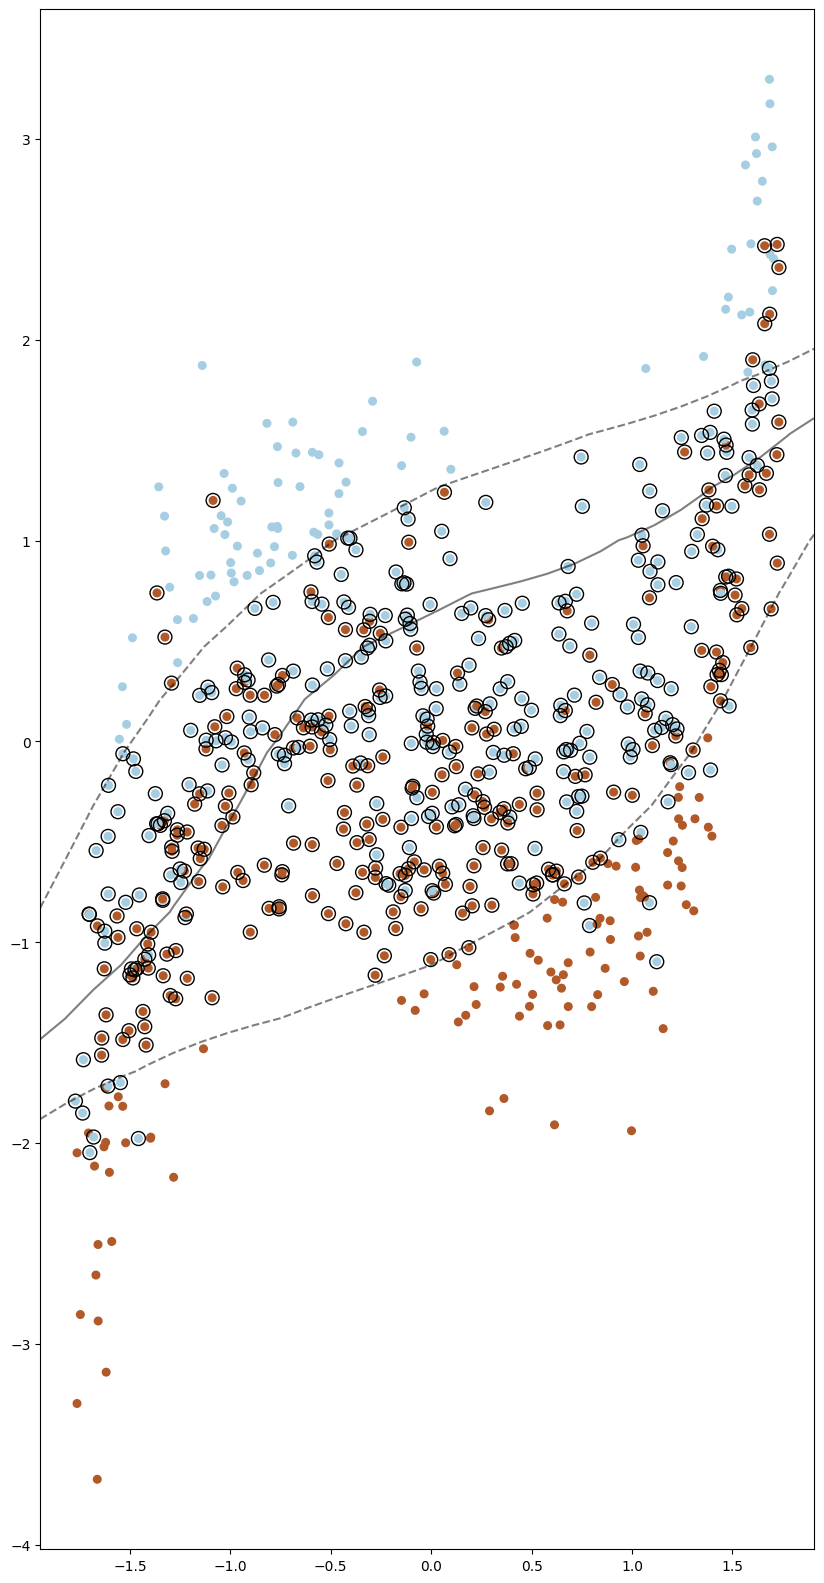

Accuracy of the model is 0.6827794561933535


In [ ]:
classifier2 = svm.SVC(kernel = 'poly')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plt.figure(figsize=(20, 20))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

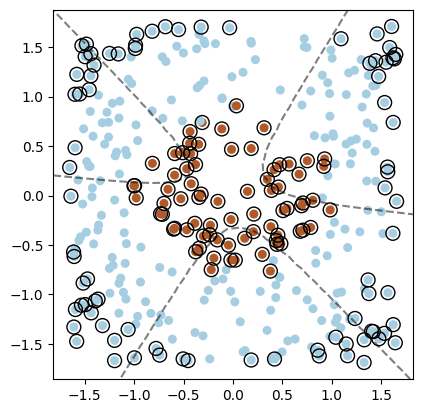

Accuracy of the model is 0.8


In [ ]:
classifier3 = svm.SVC(kernel = 'poly')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

# **C=10 and gamma = 10**

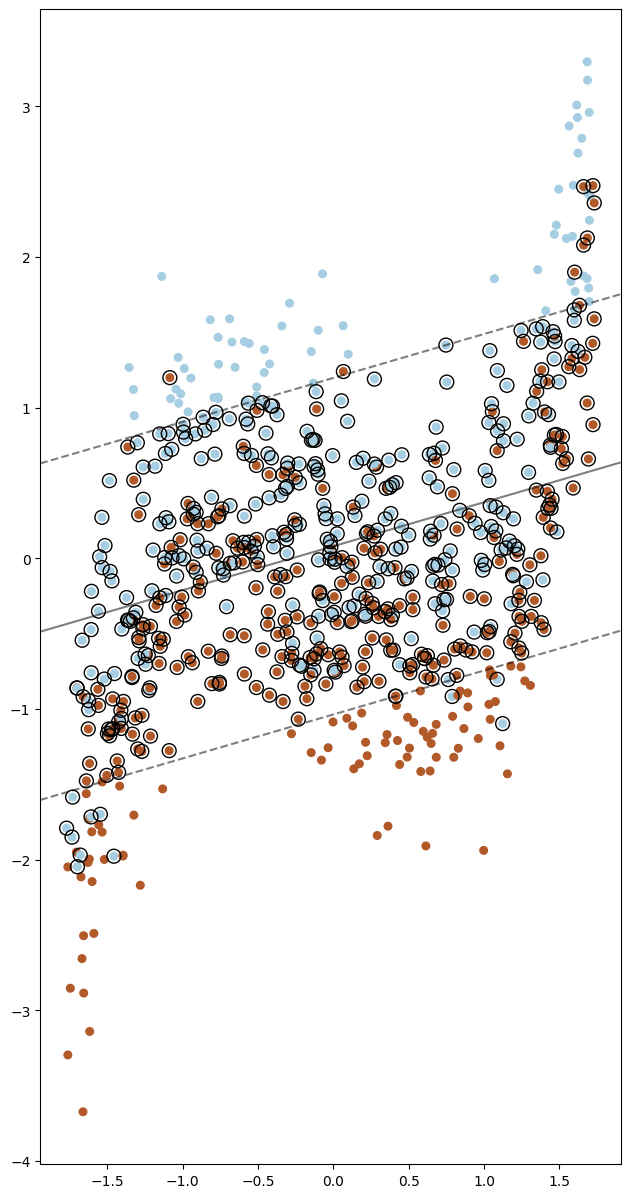

Accuracy of the model is 0.6888217522658611


In [ ]:
classifier2 = svm.SVC(C = 10, kernel = 'linear')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plt.figure(figsize=(15, 15))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

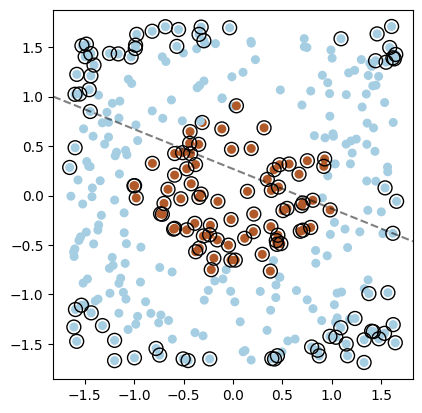

Accuracy of the model is 0.8


In [ ]:
classifier3 = svm.SVC(C = 10, kernel = 'linear')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

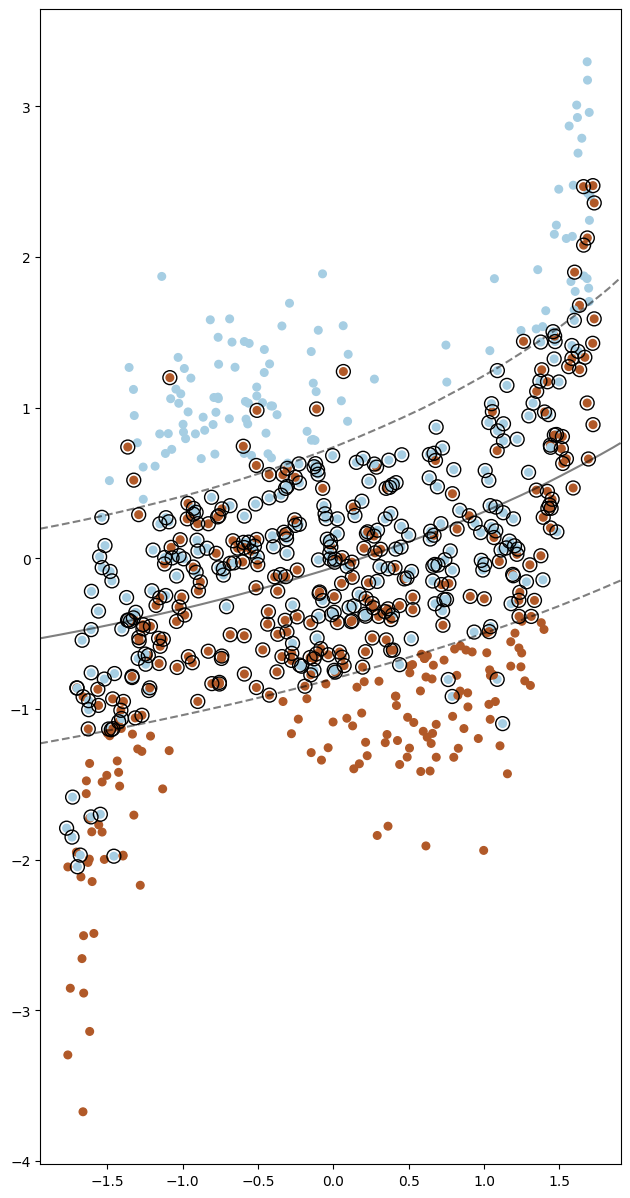

Accuracy of the model is 0.6827794561933535


In [ ]:
classifier2 = svm.SVC(C = 10, gamma = 10, kernel = 'rbf')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plt.figure(figsize=(15, 15))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

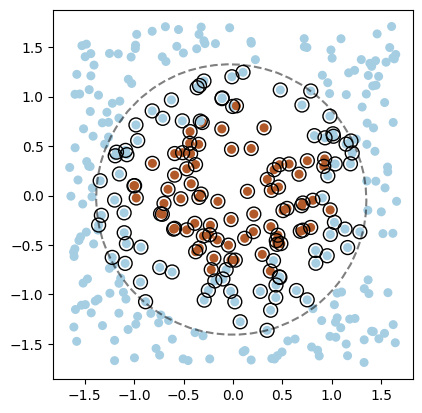

Accuracy of the model is 0.8


In [ ]:
classifier3 = svm.SVC(C = 10, gamma = 10, kernel = 'rbf')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

In this case, increasing the value of C did not help and the linear model is still trying to classify similar to the previous case except that the margins have broadened.

however for rbf, the decision boundary is more linear than before due to incease in gamma. There is a lot of misclassification. and the accuracy for test eror has gone down. Due to increase in C the model is trying to increase the marginal plane distance and trying to accommodate as much points as possible within the first marginal plane for dataset 3.

**FOr reference**

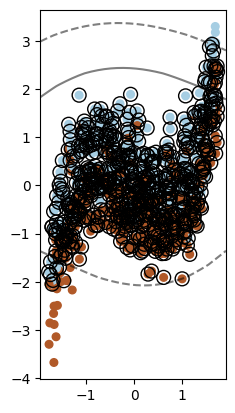

Accuracy of the model is 0.48036253776435045


In [ ]:
classifier2 = svm.SVC(C = 0.1, gamma = 0.1, kernel = 'poly')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

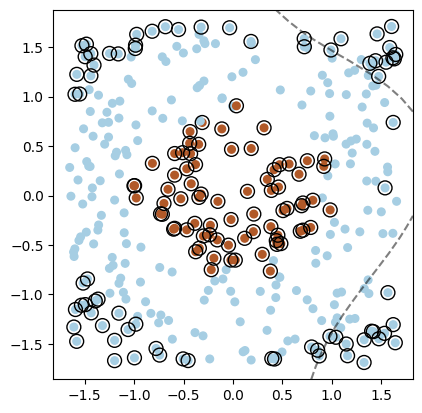

Accuracy of the model is 0.8


In [ ]:
classifier3 = svm.SVC(C = 0.1, gamma = 0.1, kernel = 'poly')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

# **C=100, gamma = 100**

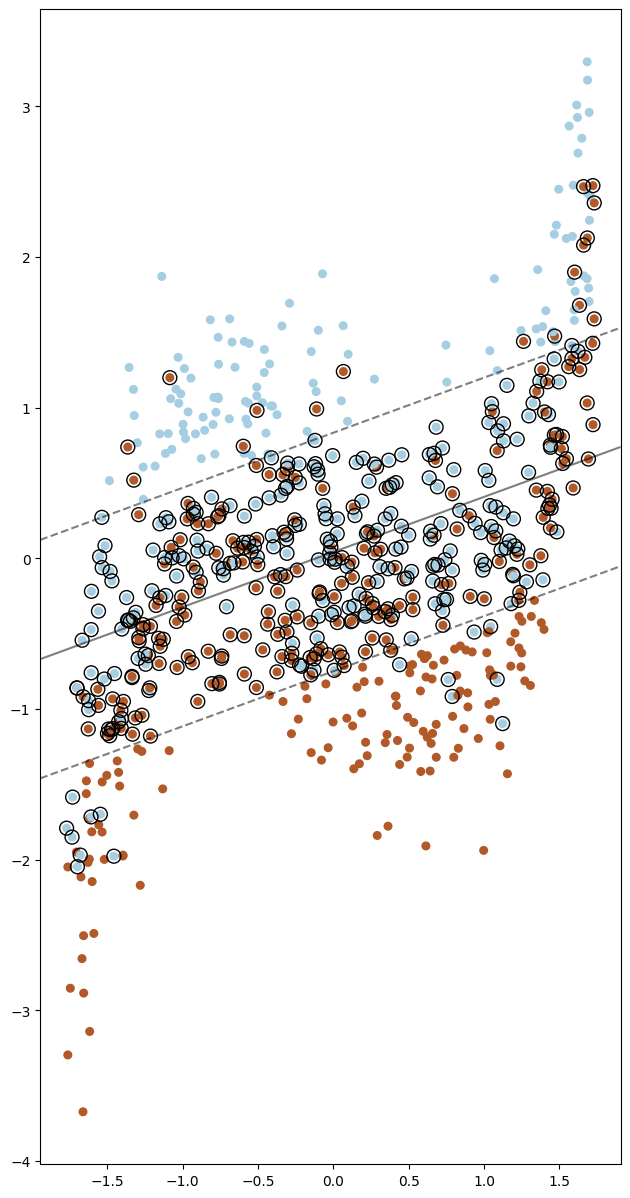

Accuracy of the model is 0.6888217522658611


In [ ]:
classifier2 = svm.SVC(C = 100, kernel = 'linear')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plt.figure(figsize=(15, 15))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

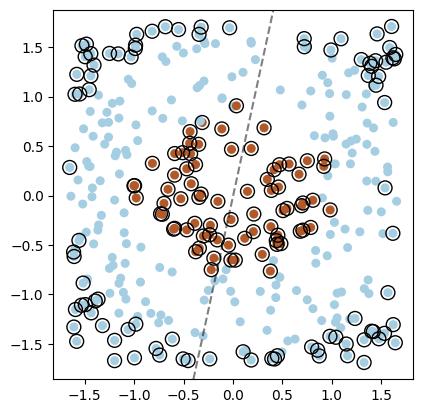

Accuracy of the model is 0.8


In [ ]:
classifier3 = svm.SVC(C = 100, kernel = 'linear')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

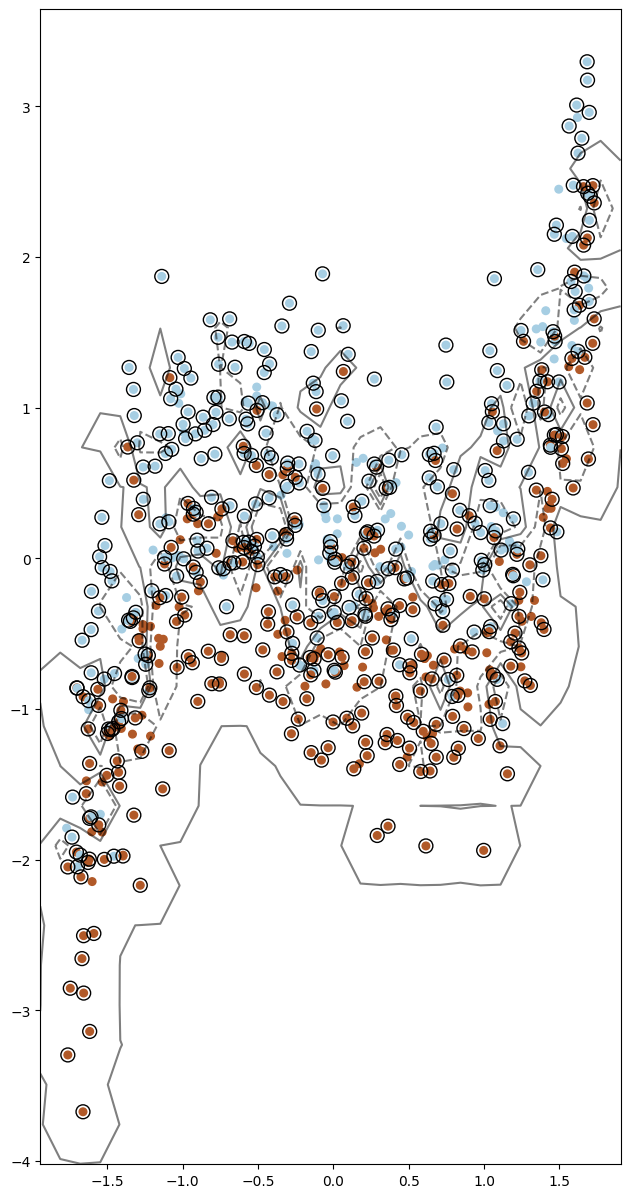

Accuracy of the model is 0.622356495468278


In [ ]:
classifier2 = svm.SVC(C = 100, gamma = 100, kernel = 'rbf')
classifier2.fit(X2_train, y2_train)

y2_test_predict = classifier2.predict(X2_test)
from sklearn.metrics import accuracy_score
plt.figure(figsize=(15, 15))
plot_margin(X2_train,y2_train,classifier2)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y2_test, y2_test_predict)}')

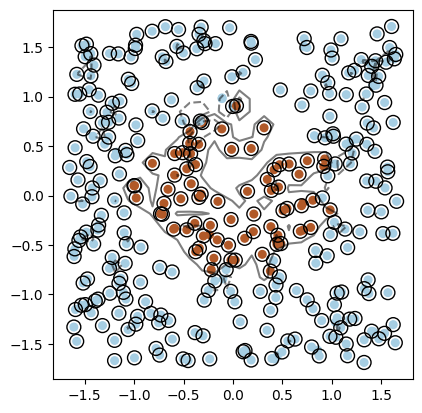

Accuracy of the model is 0.9393939393939394


In [ ]:
classifier3 = svm.SVC(C = 100, gamma = 100, kernel = 'rbf')
classifier3.fit(X3_train, y3_train)

y3_test_predict = classifier3.predict(X3_test)
from sklearn.metrics import accuracy_score
plot_margin(X3_train,y3_train,classifier3)
plt.show()
print(f'Accuracy of the model is {accuracy_score(y3_test, y3_test_predict)}')

We can see that the model is overfitting for dataset2, trying to find the exact decision boundary.
However it performed better for dataset3. the best combination of gamma and C values is highly dependent on the specific dataset and problem at hand. and the above case is the best example for it.

# **Grid Search SVM vs NN vs Bayesian NN vs Bayesian SVM for dataset 2**

**SVM for linear kernel**

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 0.01, 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68       176
         1.0       0.64      0.75      0.69       155

    accuracy                           0.69       331
   macro avg       0.69      0.69      0.69       331
weighted avg       0.70      0.69      0.69       331

Accuracy of the training model is 0.7298507462686568
Accuracy of the testing model is 0.6888217522658611


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


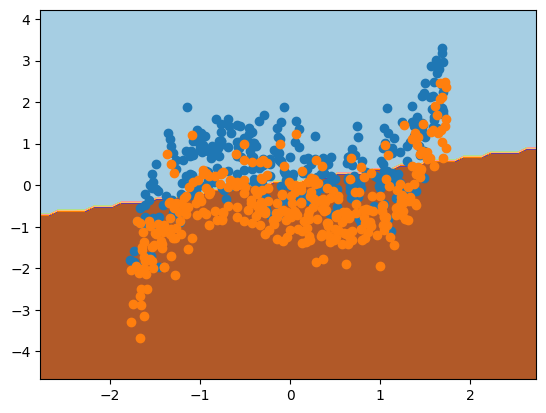

In [31]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel': ['linear']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

# fitting the model for grid search
grid.fit(X2_train, y2_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X2_test)

# print classification report
print(classification_report(y2_test, grid_predictions))
print(f'Accuracy of the training model is {grid.score(X2_train, y2_train)}')
print(f'Accuracy of the testing model is {accuracy_score(y2_test, grid_predictions)}')

plot_decisions(X2_train,y2_train,grid)
plt.show()

**SVM for rbf**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76       176
         1.0       0.72      0.75      0.74       155

    accuracy                           0.75       331
   macro avg       0.75      0.75      0.75       331
weighted avg       0.75      0.75      0.75       331

Accuracy of the training model is 0.7731343283582089
Accuracy of the testing model is 0.7462235649546828


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


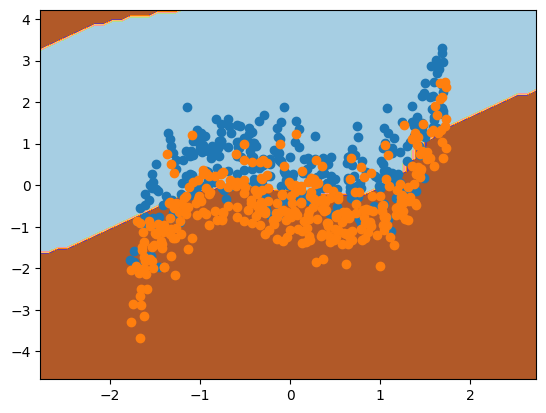

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma':['scale', 'auto'],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

# fitting the model for grid search
grid.fit(X2_train, y2_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X2_test)

# print classification report
print(classification_report(y2_test, grid_predictions))
print(f'Accuracy of the training model is {grid.score(X2_train, y2_train)}')
print(f'Accuracy of the testing model is {accuracy_score(y2_test, grid_predictions)}')

plot_decisions(X2_train,y2_train,grid)
plt.show()

**SVM for Poly**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
              precision    recall  f1-score   support

         0.0       0.81      0.51      0.63       176
         1.0       0.61      0.86      0.71       155

    accuracy                           0.68       331
   macro avg       0.71      0.69      0.67       331
weighted avg       0.72      0.68      0.67       331

Accuracy of the training model is 0.6776119402985075
Accuracy of the testing model is 0.676737160120846


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


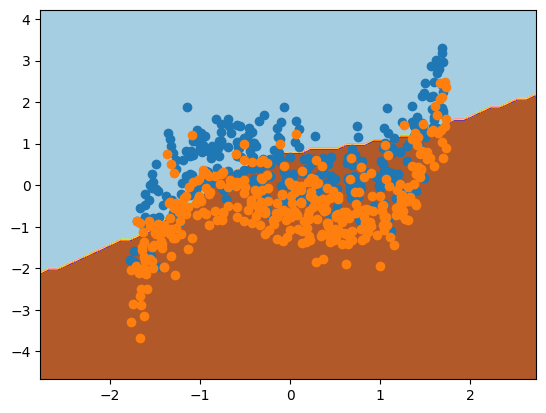

In [33]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma':['scale', 'auto'],
              'kernel': ['poly']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

# fitting the model for grid search
grid.fit(X2_train, y2_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X2_test)

# print classification report
print(classification_report(y2_test, grid_predictions))
print(f'Accuracy of the training model is {grid.score(X2_train, y2_train)}')
print(f'Accuracy of the testing model is {accuracy_score(y2_test, grid_predictions)}')

plot_decisions(X2_train,y2_train,grid)
plt.show()

**NN for dataset 2**

Train Accuracy: 0.7791044776119403
Test Accuracy: 0.7673716012084593


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


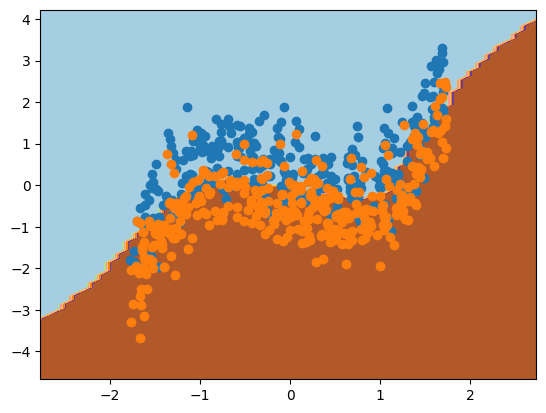

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)

mlp.fit(X2_train, y2_train)

print(f"Train Accuracy: {mlp.score(X2_train, y2_train)}")
print(f"Test Accuracy: {mlp.score(X2_test, y2_test)}")

# plot the decision boundary on the training data
plot_decisions(X2_train, y2_train, mlp)

Train Accuracy: 0.7761194029850746
Test Accuracy: 0.7885196374622356


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


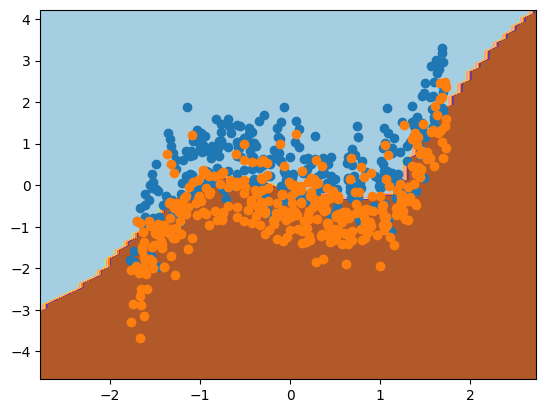

In [40]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)

mlp.fit(X2_train, y2_train)

print(f"Train Accuracy: {mlp.score(X2_train, y2_train)}")
print(f"Test Accuracy: {mlp.score(X2_test, y2_test)}")

# plot the decision boundary on the training data
plot_decisions(X2_train, y2_train, mlp)

**SVM Bayesian Optimization for dataset 2**

In [24]:
np.int = np.int32

Best parameters found: OrderedDict([('C', 1.2059819948925405), ('degree', 4), ('gamma', 0.14282378057364772), ('kernel', 'rbf')])

Best model performance:
	Train Accuracy: 0.7402985074626866
	Test Accuracy: 0.7311178247734139


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


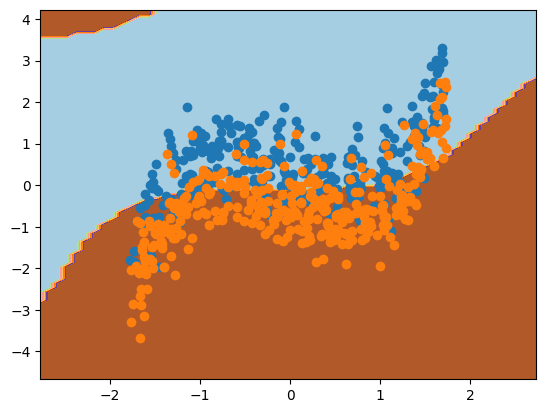

In [14]:
optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      "C": Real(1e-6, 100, "log-uniform"),
    "gamma": Real(1e-6, 100, "log-uniform"),
    "degree": Integer(1, 5),
    "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"])
    },
    n_iter=15,
)

optSVM1_lin.fit(X2_train, y2_train)

print(f"Best parameters found: {optSVM1_lin.best_params_}")

print()
print("Best model performance:")
print(f"\tTrain Accuracy: {optSVM1_lin.best_estimator_.score(X2_train, y2_train)}")
print(f"\tTest Accuracy: {optSVM1_lin.best_estimator_.score(X2_test, y2_test)}")

# plot the decision boundary
plot_decisions(X2_train, y2_train, optSVM1_lin.best_estimator_)

**NN Bayesian Optimization for dataset2**

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: OrderedDict([('layer1', 8), ('layer2', 28)])

Best model performance:
	Train Accuracy: 0.7805970149253731
	Test Accuracy: 0.7643504531722054


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


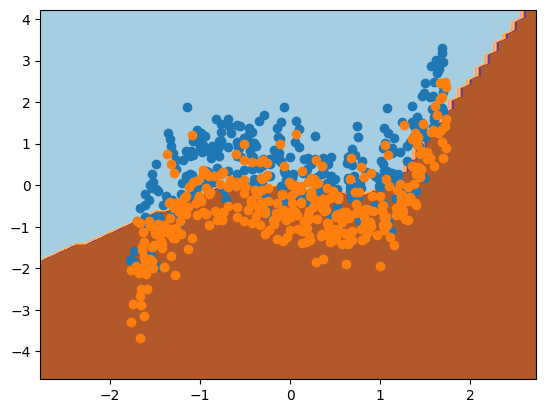

In [29]:
optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=15,
)

optNN1.fit(X2_train, y2_train)

print(f"Best parameters found: {optNN1.best_params_}")

print()
print("Best model performance:")
print(f"\tTrain Accuracy: {optNN1.best_estimator_.score(X2_train, y2_train)}")
print(f"\tTest Accuracy: {optNN1.best_estimator_.score(X2_test, y2_test)}")

# plot the decision boundary
plot_decisions(X2_train, y2_train, optNN1.best_estimator_)

**Final Reflection**

The initial approach was to manually change the values of the hyper parameters (C,gamma etc) to find the best model and their respective results was discussed after each approach in the previous submission.

 However this is time consuming and costs computation. The final version of this notebook has tried the gridsearch approach and let the algorithm find the best parameters.

 Below is the performance comparison for the following approaches with the best parameters found:

 GridSearch SVM for linear kernel: {'C': 0.01, 'kernel': 'linear'} Training model accuracy 72.98
Testing model accuracy 68.88

GridSearch SVM for RBF krnel: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} Training model accuracy 77.31
Testing model accuracy 74.62

GridSearch SVM for Poly krnel: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'} Training model accuracy 67.76
Testing model accuracy 67.67

Neural Network: MLP (50,50) Training model accuracy 77.91
Testing model accuracy 76.73

SVM Bayesian Optimization : {('C', 1.2059819948925405), ('degree', 4), ('gamma', 0.14282378057364772), ('kernel', 'rbf')} Training model accuracy 74.02
Testing model accuracy 73.11

NN Bayesian Optimization : {('layer1', 8), ('layer2', 28)} Training model accuracy 78.05
Testing model accuracy 76.43


As clearly seen, the data is not linearly separable and the noise makes it difficult to find accurate decision boundary. so we can expect quite low accuracy overall, for the model.

However we see that bayesian neural network model performs the best compared to neural networks with highest training and test accuracy by 1% for bayesian Neural networks, but neural networks in general outperform SVC.

# **Grid Search SVM vs NN vs Bayesian NN vs Bayesian SVM for dataset 3**

**SVM for linear kernel**

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 0.01, 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       132
         1.0       0.00      0.00      0.00        33

    accuracy                           0.80       165
   macro avg       0.40      0.50      0.44       165
weighted avg       0.64      0.80      0.71       165

Accuracy of the training model is 0.7791044776119403
Accuracy of the testing model is 0.8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-5-4a88a4dcbac0>:26: UserWarning: N

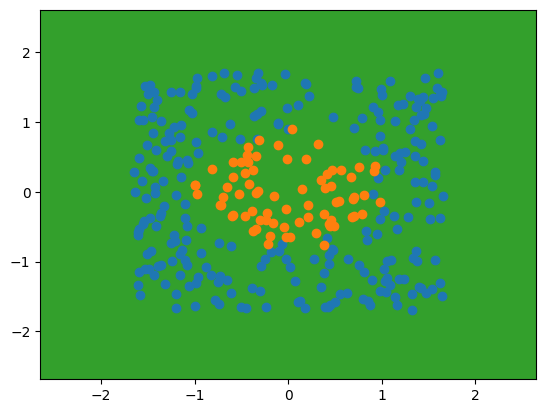

In [34]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel': ['linear']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

# fitting the model for grid search
grid.fit(X3_train, y3_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X3_test)

# print classification report
print(classification_report(y3_test, grid_predictions))
print(f'Accuracy of the training model is {grid.score(X3_train, y3_train)}')
print(f'Accuracy of the testing model is {accuracy_score(y3_test, grid_predictions)}')

plot_decisions(X3_train,y3_train,grid)
plt.show()

**SVM for rbf**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       132
         1.0       0.89      0.94      0.91        33

    accuracy                           0.96       165
   macro avg       0.94      0.95      0.94       165
weighted avg       0.96      0.96      0.96       165

Accuracy of the training model is 0.9641791044776119
Accuracy of the testing model is 0.9636363636363636


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


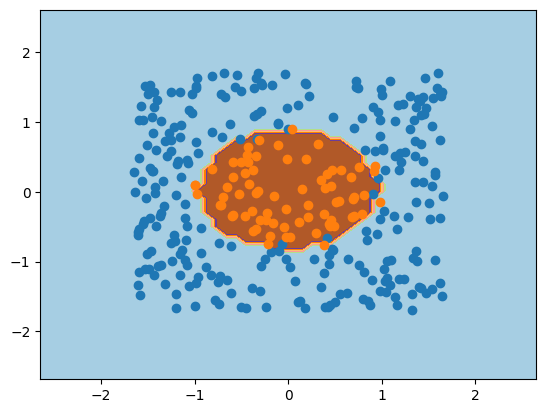

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma':['scale', 'auto'],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

# fitting the model for grid search
grid.fit(X3_train, y3_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X3_test)

# print classification report
print(classification_report(y3_test, grid_predictions))
print(f'Accuracy of the training model is {grid.score(X3_train, y3_train)}')
print(f'Accuracy of the testing model is {accuracy_score(y3_test, grid_predictions)}')

plot_decisions(X3_train,y3_train,grid)
plt.show()

**SVM for Poly**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       132
         1.0       0.00      0.00      0.00        33

    accuracy                           0.80       165
   macro avg       0.40      0.50      0.44       165
weighted avg       0.64      0.80      0.71       165

Accuracy of the training model is 0.7791044776119403
Accuracy of the testing model is 0.8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-5-4a88a4dcbac0>:26: UserWarning: N

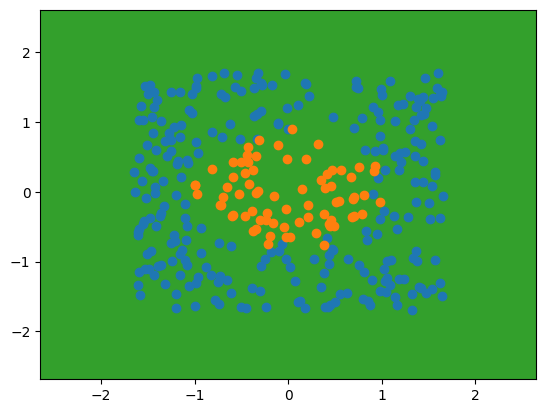

In [36]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma':['scale', 'auto'],
              'kernel': ['poly']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1)

# fitting the model for grid search
grid.fit(X3_train, y3_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X3_test)

# print classification report
print(classification_report(y3_test, grid_predictions))
print(f'Accuracy of the training model is {grid.score(X3_train, y3_train)}')
print(f'Accuracy of the testing model is {accuracy_score(y3_test, grid_predictions)}')

plot_decisions(X3_train,y3_train,grid)
plt.show()

**NN for Dataset 3**

Train Accuracy: 0.9791044776119403
Test Accuracy: 0.9757575757575757


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


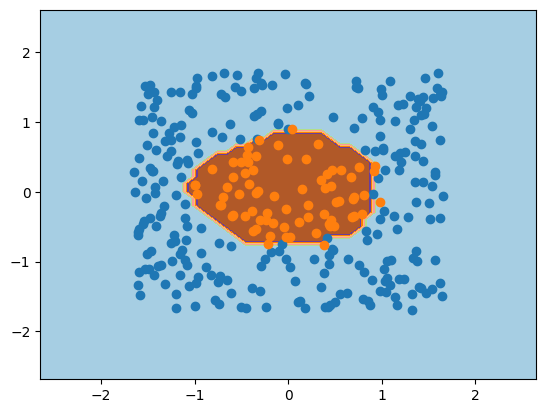

In [37]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)

mlp.fit(X3_train, y3_train)

print(f"Train Accuracy: {mlp.score(X3_train, y3_train)}")
print(f"Test Accuracy: {mlp.score(X3_test, y3_test)}")

# plot the decision boundary on the training data
plot_decisions(X3_train, y3_train, mlp)

**SVM Bayesian Optimization for dataset 3**

Best parameters found: OrderedDict([('C', 0.0008992878712785053), ('degree', 3), ('gamma', 3.803385708220891), ('kernel', 'rbf')])

Best model performance:
	Train Accuracy: 0.7791044776119403
	Test Accuracy: 0.8


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


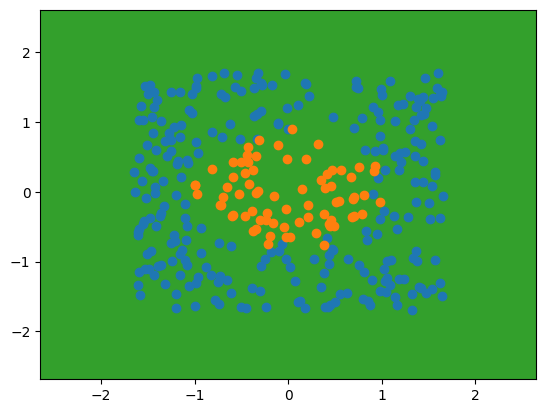

In [38]:
optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      "C": Real(1e-6, 100, "log-uniform"),
    "gamma": Real(1e-6, 100, "log-uniform"),
    "degree": Integer(1, 5),
    "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"])
    },
    n_iter=15,
)

optSVM1_lin.fit(X3_train, y3_train)

print(f"Best parameters found: {optSVM1_lin.best_params_}")

print()
print("Best model performance:")
print(f"\tTrain Accuracy: {optSVM1_lin.best_estimator_.score(X3_train, y3_train)}")
print(f"\tTest Accuracy: {optSVM1_lin.best_estimator_.score(X3_test, y3_test)}")

# plot the decision boundary
plot_decisions(X3_train, y3_train, optSVM1_lin.best_estimator_)

**NN Bayesian Optimization for dataset 3**

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: OrderedDict([('layer1', 35), ('layer2', 53)])

Best model performance:
	Train Accuracy: 0.9791044776119403
	Test Accuracy: 0.9757575757575757


<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


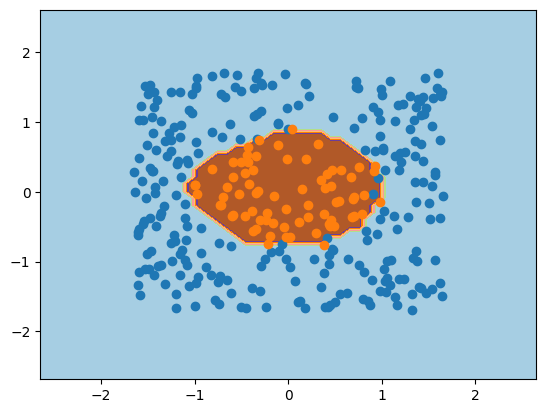

In [39]:
optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=15,
)

optNN1.fit(X3_train, y3_train)

print(f"Best parameters found: {optNN1.best_params_}")

print()
print("Best model performance:")
print(f"\tTrain Accuracy: {optNN1.best_estimator_.score(X3_train, y3_train)}")
print(f"\tTest Accuracy: {optNN1.best_estimator_.score(X3_test, y3_test)}")

# plot the decision boundary
plot_decisions(X3_train, y3_train, optNN1.best_estimator_)

 **Final Reflection**

 Below is the performance comparison for the following approaches with the best hyper-parameters found:

 GridSearch SVM for linear kernel: {'C': 0.01, 'kernel': 'linear'} Training model accuracy 77.91
Testing model accuracy 80.0

GridSearch SVM for RBF krnel: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} Training model accuracy 96.4
Testing model accuracy 96.3

GridSearch SVM for Poly krnel: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'} Training model accuracy 77.9
Testing model accuracy 80.0

Neural Network: MLP (50,50) Training model accuracy 97.91
Testing model accuracy 97.5

SVM Bayesian Optimization : {('C', 0.0008992878712785053), ('degree', 3), ('gamma', 3.803385708220891), ('kernel', 'rbf')} Training model accuracy 77.9
Testing model accuracy 80.0

NN Bayesian Optimization : {('layer1', 35), ('layer2', 53)} Training model accuracy 97.9
Testing model accuracy 97.5


The best parameters found for C are different for different kernels. This dataset is non-linearly separable with less noise.

Yet again, we see that neural network model performs the best compared to SVC models. The hyperparameter - different layers of neurons and diff number of neurons has helped the model learn better and classify better.